# PyMC and Universal Samplers

## Part A: `import pymc`

In [30]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [31]:
print(f"Running on PyMC v{pymc.__version__}")

Running on PyMC v5.20.1


In [32]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

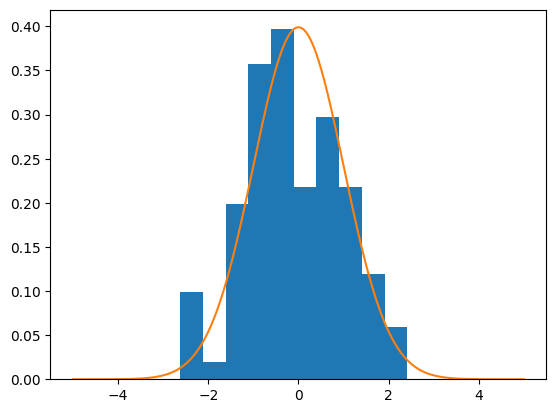

In [33]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = \
stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [34]:
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma:

    # Priors for unknown model parameters
    
    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau  
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...
    
    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2, 
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

In [35]:
# pymc.model_to_graphviz(conjugate_normal_gamma)

In [36]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.06        3            2207.09 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.09        3            1703.91 draws/s   0:00:05   0:00:00

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## `idata` and `arviz as az`

In [37]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [38]:
idata.posterior

<xarray.Dataset> Size: 400kB
Dimensions:  (chain: 2, draw: 10000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    theta    (chain, draw) float64 160kB -0.03711 0.007441 ... -0.1959 0.06757
    tau      (chain, draw) float64 160kB 0.7161 0.8001 0.8744 ... 0.6996 0.6036
Attributes:
    created_at:                 2025-02-14T05:35:01.993912+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              10.274752140045166
    tuning_steps:               100

In [39]:
idata.posterior['theta']

<xarray.DataArray 'theta' (chain: 2, draw: 10000)> Size: 160kB
array([[-0.0371063 ,  0.007441  , -0.10156175, ..., -0.0131648 ,
        -0.06897982, -0.06874435],
       [-0.06156469,  0.00279164, -0.14082196, ...,  0.07721081,
        -0.19587132,  0.06757243]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [40]:
idata.posterior['tau']

<xarray.DataArray 'tau' (chain: 2, draw: 10000)> Size: 160kB
array([[0.71614639, 0.80011805, 0.87437492, ..., 0.90134459, 0.77877348,
        0.92681028],
       [0.75159104, 0.67049398, 0.77200135, ..., 0.8399822 , 0.69964251,
        0.60361032]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

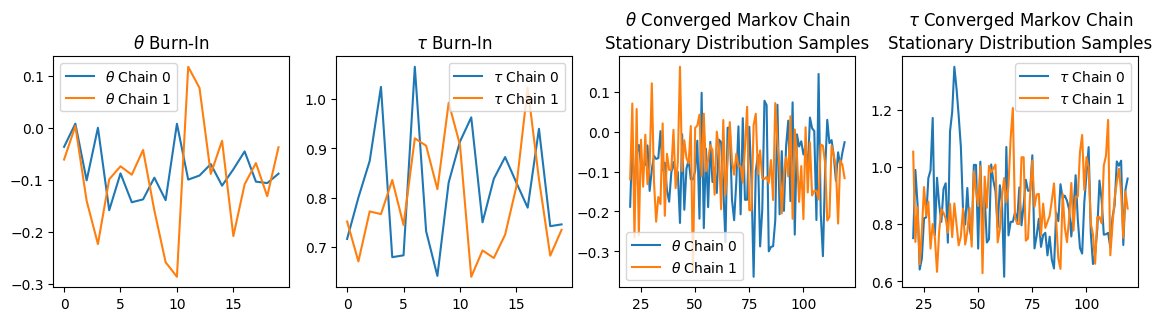

In [41]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

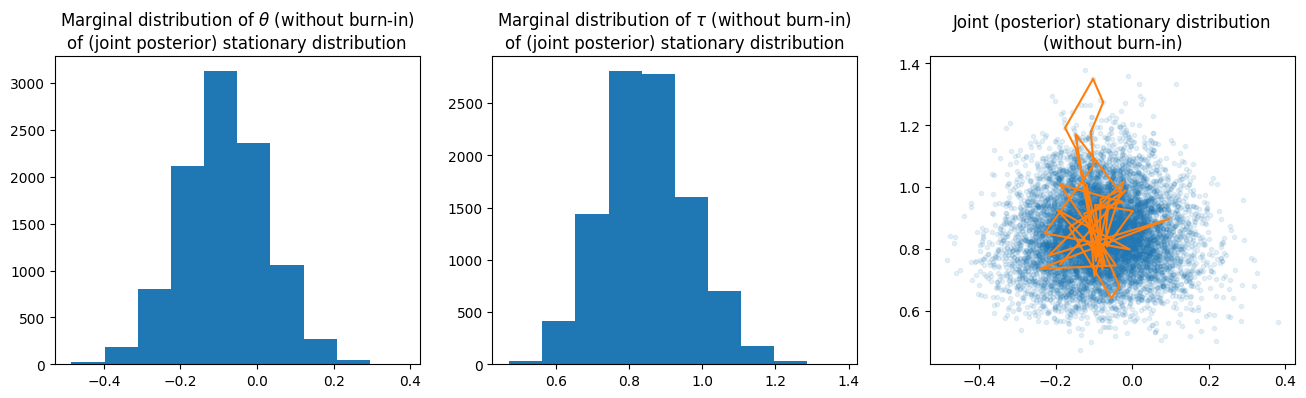

In [42]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [43]:
import arviz as az

In [44]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

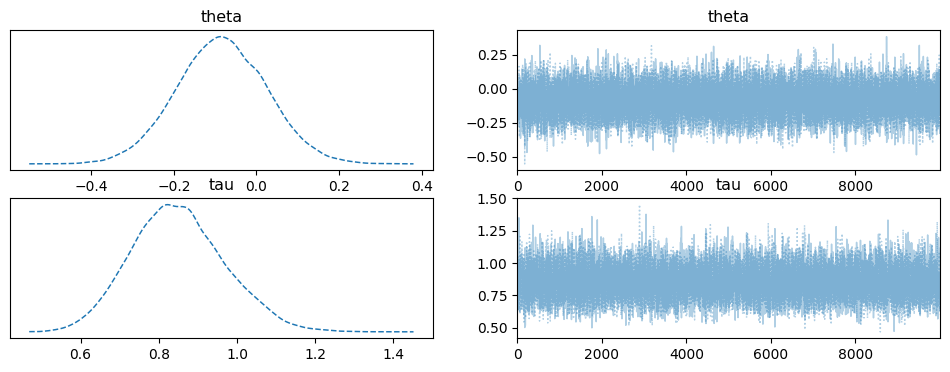

In [45]:
az.plot_trace(idata, combined=True);

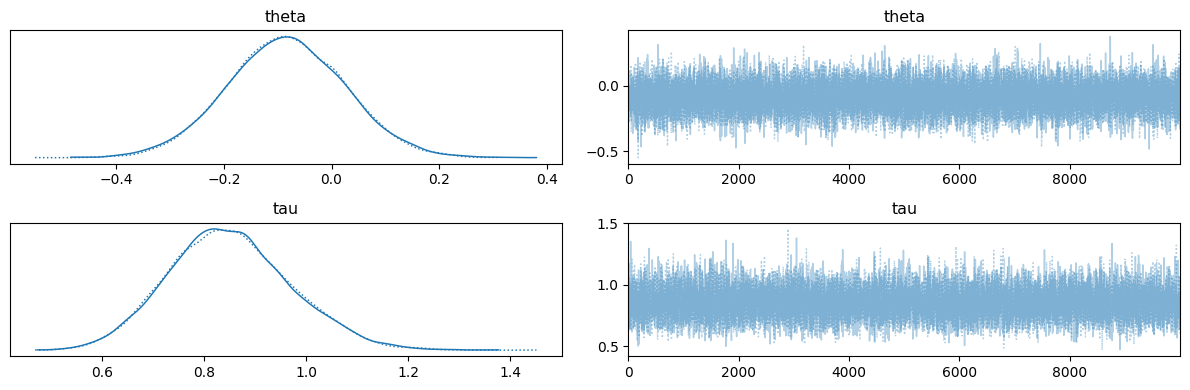

In [46]:
az.plot_trace(idata)
plt.tight_layout()

In [47]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape    

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   1100    0             0.08        3            2209.84 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1100    0             0.05        7            694.08 draws/s    0:00:01   0:00:00

Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [48]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

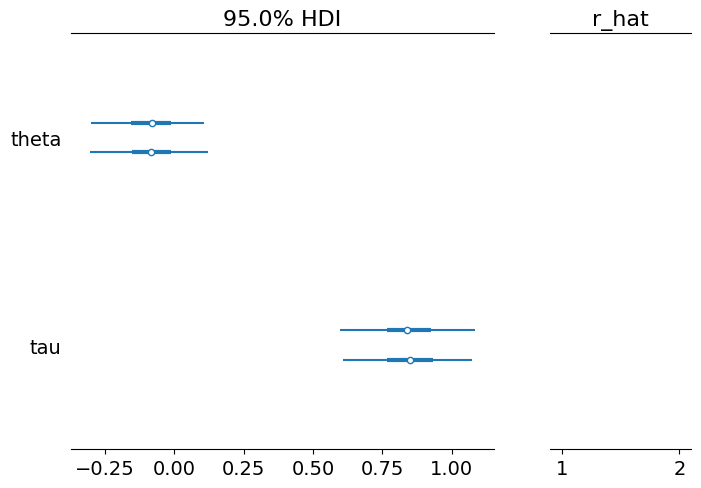

In [49]:
az.plot_forest(idata, var_names=["theta", "tau"], 
               combined=False, hdi_prob=0.95, r_hat=True);


## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [50]:
az.summary(idata, round_to=5)#2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.08244,0.10728,-0.27916,0.12186,0.00241,0.00206,2018.5724,1386.40729,1.00136
tau,0.84952,0.12051,0.61109,1.07120,0.00326,0.00231,1340.1787,925.88747,1.00291


In [51]:
theta.ravel().shape

(2000,)

### `mean` and `sd`

In [52]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

(-0.08244, 0.84952)

In [53]:
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

(0.10728, 0.12051)

### `hdi_3%` and `hdi_97%`

In [54]:
az.summary(idata, round_to=5)#2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.08244,0.10728,-0.27916,0.12186,0.00241,0.00206,2018.5724,1386.40729,1.00136
tau,0.84952,0.12051,0.61109,1.07120,0.00326,0.00231,1340.1787,925.88747,1.00291


In [55]:
np.quantile(theta,[0.05,0.95]).round(round_to)

array([-0.26185,  0.09062])

In [56]:
np.quantile(theta,[0.025,0.975]).round(round_to)

array([-0.29246,  0.12916])

In [57]:
np.quantile(theta,[0.03,0.97]).round(round_to)

array([-0.28215,  0.11755])

In [58]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

array([-0.30015,  0.10228])

In [59]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

array([0.6155 , 1.07737])

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [60]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.08244,0.10728,-0.27916,0.12186,0.00241,0.00206,2018.5724,1386.40729,1.00136
tau,0.84952,0.12051,0.61109,1.07120,0.00326,0.00231,1340.1787,925.88747,1.00291


In [61]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

0.0023877925861549567

In [62]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5

0.0032918628354005417

In [63]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


1.501998407463751e-07

In [64]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method 
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the 
#  standard deviation (SD) of a single variable 
#  without assuming normality using moments of moments 
#  and first order Taylor series approximation 
#  (Kenney and Keeping, 1951, p. 141)."

0.003613339481200061

In [65]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

0.004704904720887136

In [66]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.08244,0.10728,-0.27916,0.12186,0.00241,0.00206,2018.5724,1386.40729,1.00136
tau,0.84952,0.12051,0.61109,1.07120,0.00326,0.00231,1340.1787,925.88747,1.00291


### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [67]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail

0.05


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1687.1347312549574

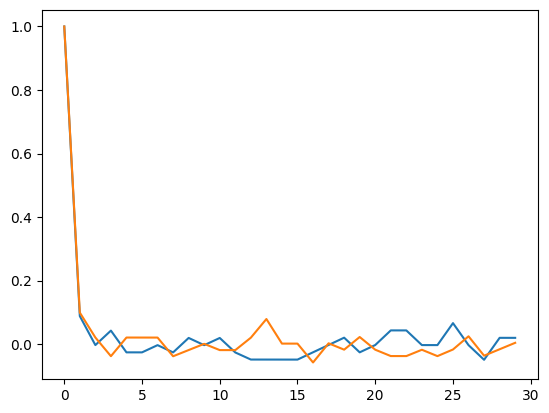

In [68]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k], 
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [69]:
autocorrelations[:,:10]

array([[ 1.        ,  0.08846206, -0.00274023,  0.04279248, -0.02562929,
        -0.0256792 , -0.00293524, -0.02577935,  0.01976285, -0.00308259],
       [ 1.        ,  0.0994709 ,  0.02110797, -0.03768509,  0.02099552,
         0.02093911,  0.02088258, -0.03792451, -0.01840006,  0.00112653]])

In [70]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

0.1


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

950.7548374275975

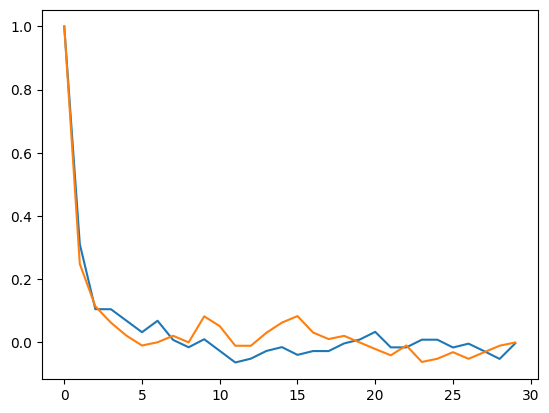

In [71]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k], 
                    tau_in_tail[c,t_plus_k:])[0,1]
        
for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [72]:
autocorrelations[:,:20]

array([[ 1.00000000e+00,  3.10851043e-01,  1.05225535e-01,
         1.05135483e-01,  6.87632809e-02,  3.23835457e-02,
         6.85748360e-02,  7.99200799e-03, -1.52725103e-02,
         1.00998890e-02, -2.66666667e-02, -6.34408602e-02,
        -5.13239297e-02, -2.69788183e-02, -1.48561508e-02,
        -3.94165115e-02, -2.72930649e-02, -2.73982829e-02,
        -3.03936223e-03,  9.09090909e-03],
       [ 1.00000000e+00,  2.48252757e-01,  1.14271267e-01,
         6.26601372e-02,  2.13377740e-02, -9.69204962e-03,
         4.87223345e-04,  2.09743036e-02,  2.38968487e-04,
         8.25792091e-02,  5.15365150e-02, -1.04462052e-02,
        -1.05728987e-02,  3.05531755e-02,  6.27680169e-02,
         8.33655587e-02,  3.14557024e-02,  1.06131573e-02,
         2.08496599e-02,  1.47264720e-16]])

In [73]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.08244,0.10728,-0.27916,0.12186,0.00241,0.00206,2018.5724,1386.40729,1.00136
tau,0.84952,0.12051,0.61109,1.07120,0.00326,0.00231,1340.1787,925.88747,1.00291


#### Reminder 

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


2105.0778972555804

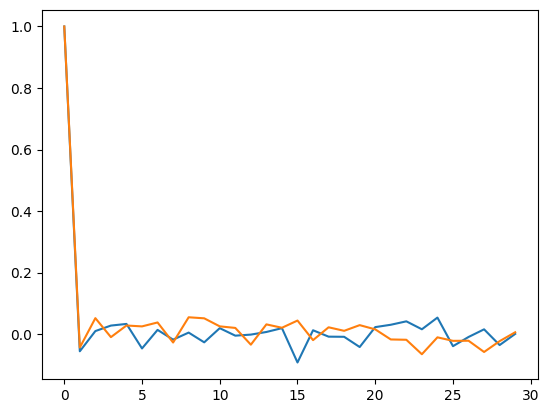

In [74]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k], 
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [75]:
autocorrelations[:,:10]

array([[ 1.        , -0.05586867,  0.00980427,  0.02768915,  0.03303409,
        -0.04667089,  0.01367553, -0.01801158,  0.00487394, -0.02678575],
       [ 1.        , -0.04372314,  0.05178595, -0.0098564 ,  0.0278792 ,
         0.02503356,  0.03781901, -0.02734413,  0.05467176,  0.05127272]])

1248.7748133829984

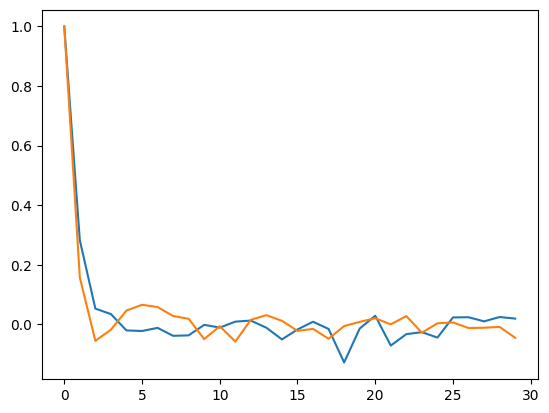

In [76]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k], 
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [77]:
autocorrelations[:,:10]

array([[ 1.        ,  0.2827783 ,  0.05315516,  0.03484941, -0.0200592 ,
        -0.02194438, -0.01146361, -0.03808663, -0.03658988, -0.00130601],
       [ 1.        ,  0.15769158, -0.05503185, -0.01751215,  0.04673893,
         0.06596459,  0.0585329 ,  0.0282814 ,  0.01908237, -0.0493463 ]])

In [78]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.08244,0.10728,-0.27916,0.12186,0.00241,0.00206,2018.5724,1386.40729,1.00136
tau,0.84952,0.12051,0.61109,1.07120,0.00326,0.00231,1340.1787,925.88747,1.00291


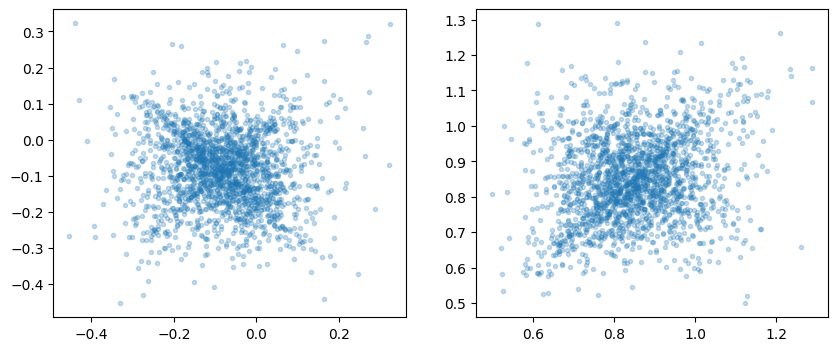

In [79]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $ 

In [80]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.08244,0.10728,-0.27916,0.12186,0.00241,0.00206,2018.5724,1386.40729,1.00136
tau,0.84952,0.12051,0.61109,1.07120,0.00326,0.00231,1340.1787,925.88747,1.00291


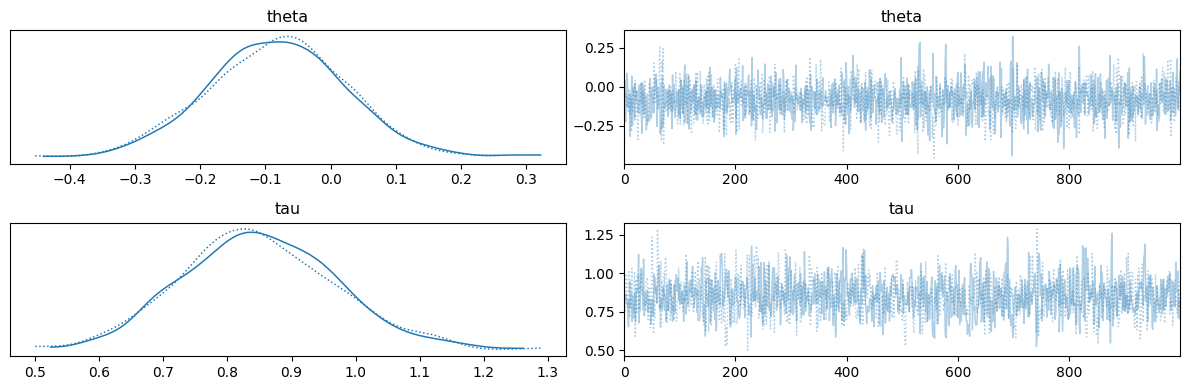

In [81]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


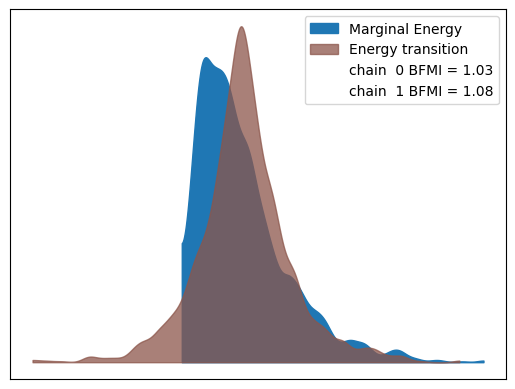

In [82]:
az.plot_energy(idata);

## Part D: Samplers


In [83]:
pymc.sample?

Signature:
pymc.sample(
    draws: int = 1000,
    *,
    tune: int = 1000,
    chains: int | None = None,
    cores: int | None = None,
    random_seed: None | int | collections.abc.Sequence[int] | numpy.ndarray | numpy.random.mtrand.RandomState | numpy.random._generator.Generator = None,
    progressbar: Union[bool, Literal['combined', 'split', 'combined+stats', 'stats+combined', 'split+stats', 'stats+split']] = True,
    progressbar_theme: rich.theme.Theme | None = None,
    step=None,
    var_names: collections.abc.Sequence[str] | None = None,
    nuts_sampler: Literal['pymc', 'nutpie', 'numpyro', 'blackjax'] = 'pymc',
    initvals: dict[pytensor.graph.basic.Variable | str, numpy.ndarray | pytensor.graph.basic.Variable | str] | collections.abc.Sequence[dict[pytensor.graph.basic.Variable | str, numpy.ndarray | pytensor.graph.basic.Variable | str] | None] | None = None,
    init: str = 'auto',
    jitter_max_retries: int = 10,
    n_init: int = 200000,
    trace: pymc.backends.base.B

 Progress                                   Draws   Sampling Speed    Elapsed   Remaining  
 ────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    2534.50 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    2412.18 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    2065.60 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    1044.13 draws/s   0:00:01   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.09,0.11,-0.30,0.11,0.0,0.0,2275.08,2383.30,1.0
tau,0.85,0.12,0.63,1.07,0.0,0.0,2243.22,2452.41,1.0


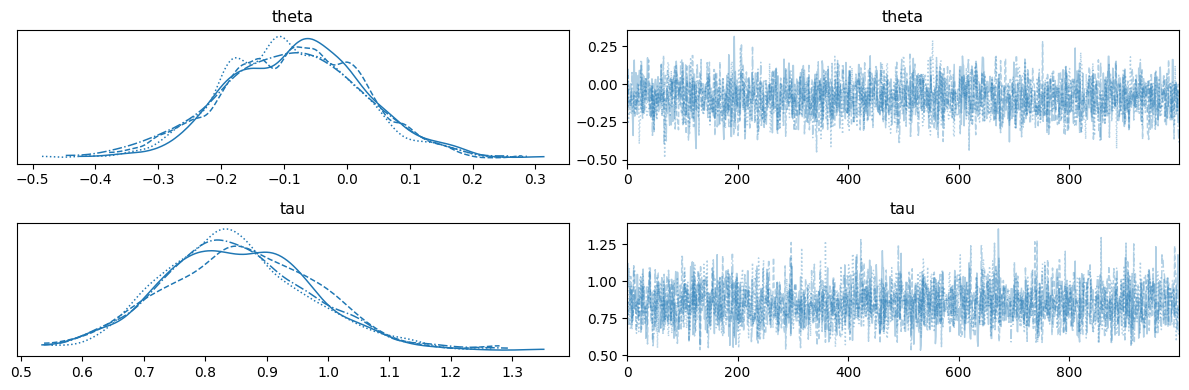

In [84]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)
    
display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()    

In [85]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

array([0.29429429, 0.32732733, 0.34734735, 0.28728729])

In [86]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

array([0.29429429, 0.32732733, 0.34734735, 0.28728729])

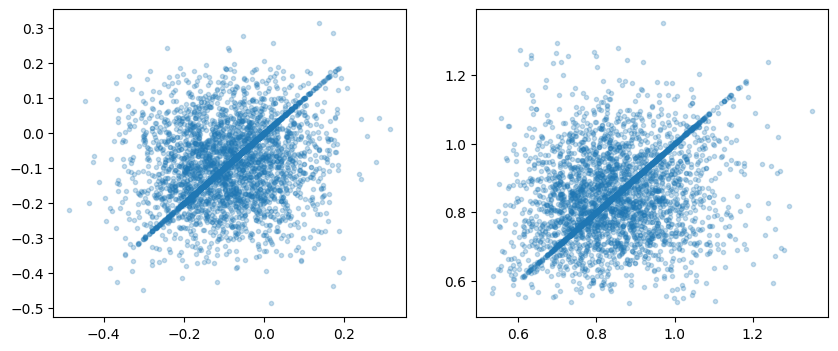

In [87]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1], 
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1], 
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.78        3            1602.89 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             1.20        3            1571.79 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             1.22        3            1545.89 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.80        3            862.49 draws/s    0:00:02   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.08,0.11,-0.28,0.12,0.0,0.0,3367.62,2537.61,1.0
tau,0.85,0.12,0.63,1.08,0.0,0.0,3458.24,2770.26,1.0


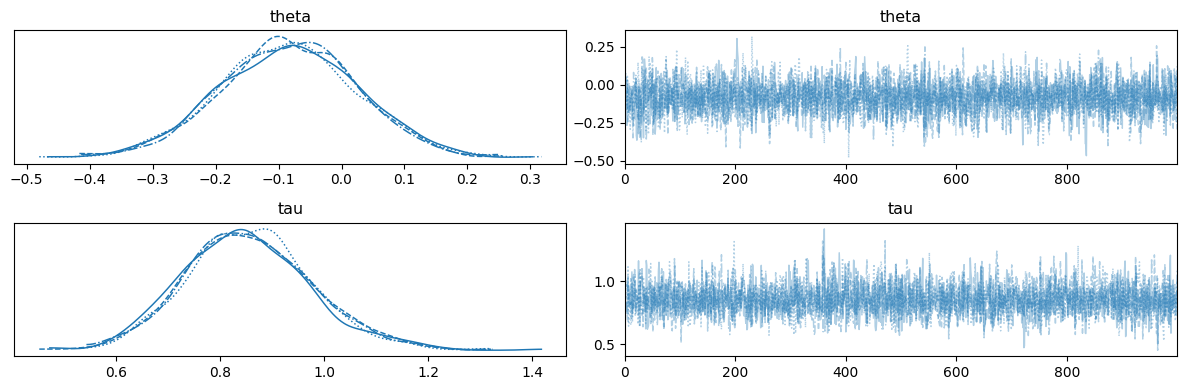

In [88]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)
    
display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()    

In [89]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.978878,0.930926,0.962120,0.972065,0.866225,0.985535,0.957358,0.937270,0.984515,0.954033,...,0.993185,0.955833,0.826090,0.897746,0.876320,0.996902,0.983104,0.660436,0.800799,0.982530
1,0.832423,0.873778,0.973144,0.914443,0.855147,1.000000,0.833401,0.986627,0.952722,0.991587,...,0.821656,0.939763,0.998924,0.992755,0.950891,0.958148,0.911919,1.000000,1.000000,0.884835
2,1.000000,0.855142,0.922014,0.993013,0.936915,0.768649,0.936046,0.924702,0.908114,0.890787,...,0.804750,0.992393,0.823288,1.000000,0.934061,0.953527,1.000000,0.919766,0.985897,0.927925
3,1.000000,0.985196,0.994065,0.881601,0.643180,0.987592,1.000000,1.000000,0.888403,1.000000,...,0.998672,0.988895,0.972254,1.000000,0.609660,1.000000,0.916628,0.979465,0.633560,0.466017


array([0.08457164, 0.08145507, 0.10054197, 0.09556807])

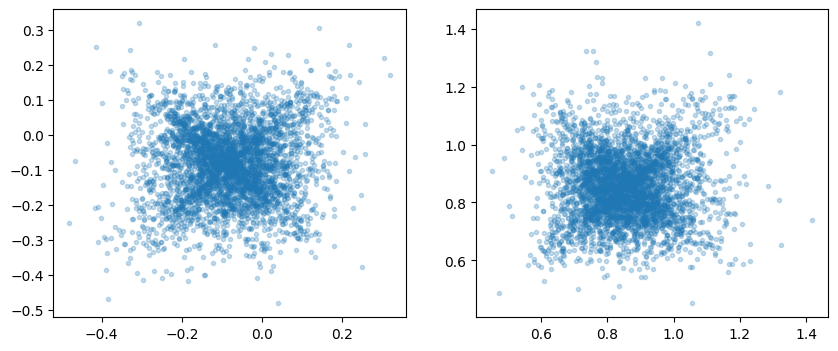

In [90]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1], 
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1], 
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

 Progress                          Draws   Tuning   Steps out   Steps in   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    1           3          3038.91 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    0           0          2904.43 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    0           4          2571.80 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    1           1          1117.53 draws/s   0:00:01   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.09,0.11,-0.29,0.12,0.0,0.0,3895.28,2754.01,1.0
tau,0.85,0.12,0.64,1.08,0.0,0.0,3151.66,2665.52,1.0


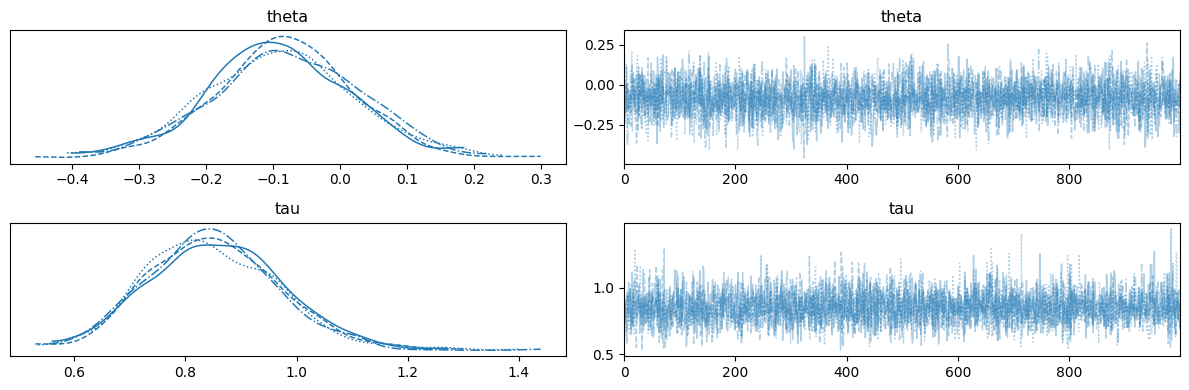

In [91]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()    

In [92]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

In [93]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

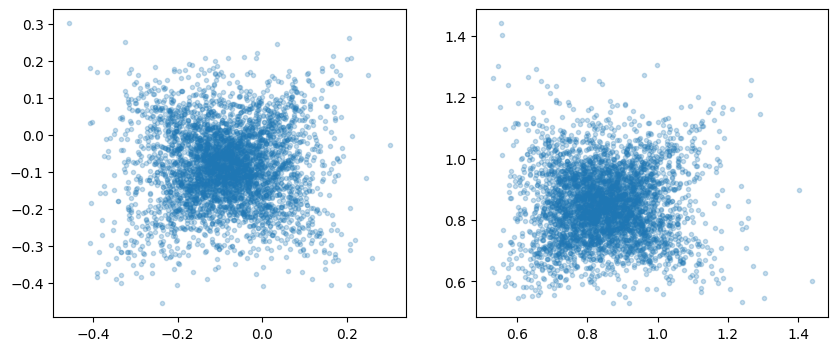

In [94]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1], 
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1], 
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

 Progress                         Draws   Tuning   Scaling   Accept Rate   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    1.00      0.00          2581.82 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    1.00      0.01          2441.59 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    1.00      1.25          2241.23 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    1.00      0.00          643.46 draws/s    0:00:01   0:00:00

Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.08,0.11,-0.30,0.12,0.01,0.0,433.77,431.13,1.01
tau,0.84,0.12,0.62,1.05,0.01,0.0,395.26,389.06,1.01


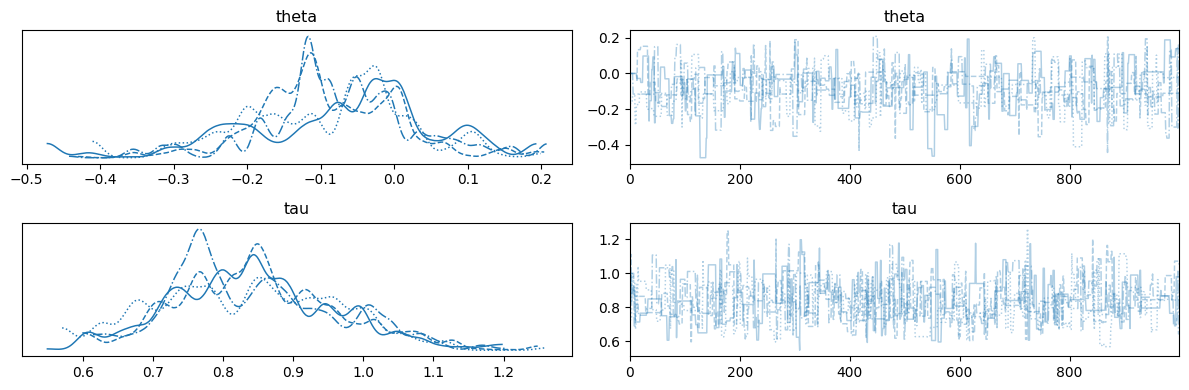

In [95]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()    

In [96]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

array([0.84984985, 0.86286286, 0.86686687, 0.86086086])

In [97]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

array([0.83283283, 0.81481481, 0.81381381, 0.80780781])

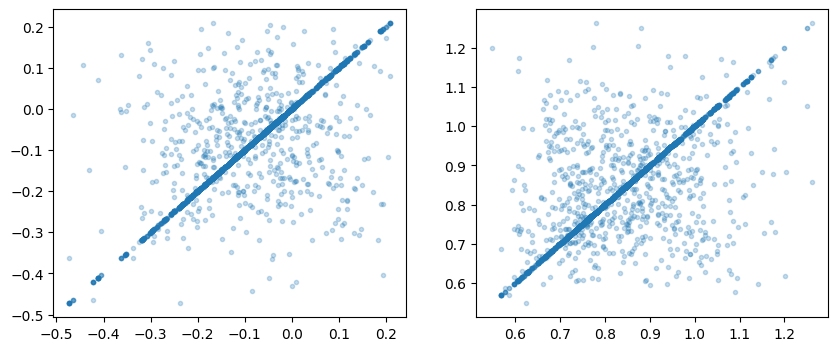

In [98]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1], 
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1], 
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

 Progress                         Draws   Tuning   Scaling   Accept Rate   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    0.10      0.69          2600.26 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    0.10      1.04          2470.04 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    0.10      0.15          2271.09 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    0.10      0.28          669.83 draws/s    0:00:01   0:00:00

Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 10 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.09,0.11,-0.30,0.10,0.01,0.00,433.87,500.87,1.01
tau,0.86,0.13,0.64,1.11,0.01,0.01,245.28,413.33,1.01


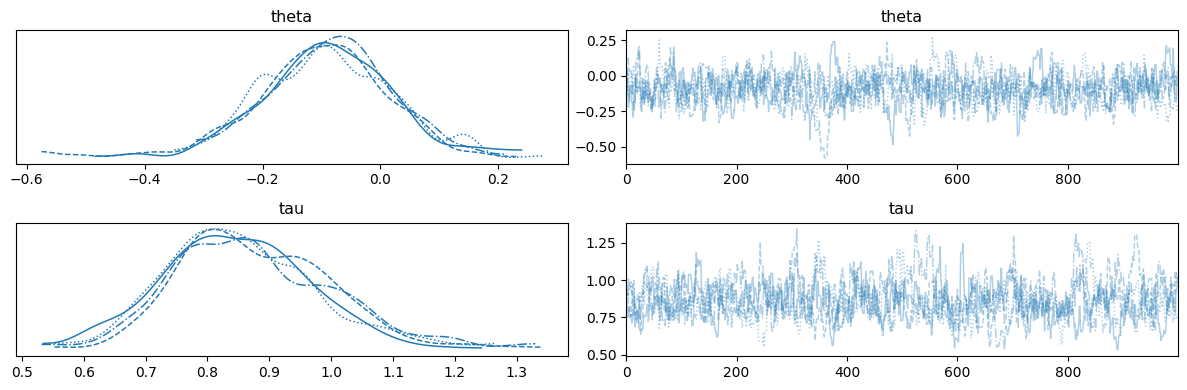

In [99]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()    

In [100]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

array([0.27827828, 0.2992993 , 0.31431431, 0.27927928])

In [101]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

array([0.22522523, 0.21721722, 0.22122122, 0.24324324])

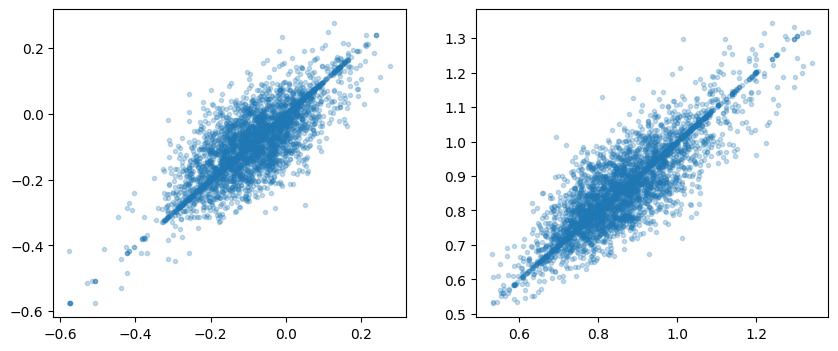

In [102]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1], 
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1], 
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- Distribution Dimensionality
- PyMC and PyTensor
- Using Data Containers

| | | |
|-|-|-|
|1|2|3|


#### Etc.

- 1.
- 2.
- 3.
- 4.
- 5.
- 6.
- 7.
- 8.
- 9.
- 10.
- 11.
- 12.
- 13.


| | | | |
|-|-|-|-|
|1|2|3|4|
|5|6|7|8|
|9|10|11|12|

Etc.


### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

In [103]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


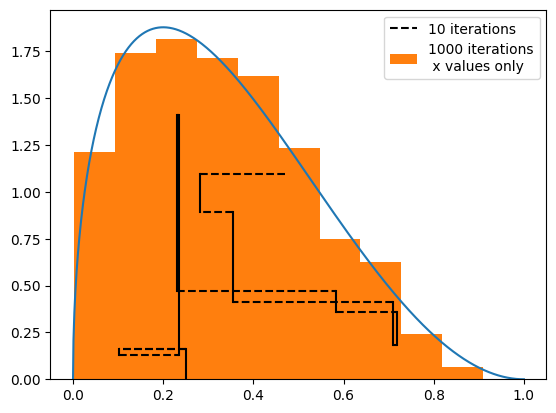

In [104]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();

# Answers

### Q1:

#### Introductory

|  ![General Overview](https://raw.githubusercontent.com/pymc-devs/brand/main/pymc/pymc_logos/PyMC_square.svg) **General Overview** | ![Simple Linear Regression](https://www.pymc.io/projects/examples/en/latest/_images/glm_linear.png) **Simple Linear Regression** | ![General API quickstart](https://www.pymc.io/projects/examples/en/latest/_images/api_quickstart.png) **General API quickstart** |
|-------------- | -------------- | -------------- | 


#### Library Fundamentals

|  ![Distribution Dimensionality](https://www.pymc.io/projects/examples/en/latest/_images/dimensionality.png) **Distribution Dimensionality** | ![PyMC and PyTensor](https://www.pymc.io/projects/examples/en/latest/_images/pytensor_pymc.png) **PyMC and PyTensor** | ![Using Data Containers](https://www.pymc.io/projects/examples/en/latest/_images/data_container.png) **Using Data Containers** |
|-------------- | -------------- | -------------- | 


#### How To

|  ![Prior and Posterior Predictive Checks](https://www.pymc.io/projects/examples/en/latest/_images/model_comparison.png) **Prior and Posterior Predictive Checks** | ![Model Comparison](https://www.pymc.io/projects/examples/en/latest/_images/posterior_predictive.png) **Model Comparison** | ![Updating Priors](https://www.pymc.io/projects/examples/en/latest/_images/updating_priors.png) **Updating Priors** | ![Automatic marginalization of discrete variables](https://www.pymc.io/projects/examples/en/latest/_images/marginalizing-models.png) **Automatic marginalization of discrete variables** | ![How to debug a model](https://www.pymc.io/projects/examples/en/latest/_images/howto_debugging.png) **How to debug a model** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![How to debug a model](https://www.pymc.io/projects/examples/en/latest/_images/howto_debugging.png) **How to debug a model** | ![How to wrap a JAX function for use in PyMC](https://www.pymc.io/projects/examples/en/latest/_images/wrapping_jax_function.png) **How to wrap a JAX function for use in PyMC** | ![Splines](https://www.pymc.io/projects/examples/en/latest/_images/spline.png) **Splines** | ![Bayesian copula estimation: Describing correlated joint distributions](https://www.pymc.io/projects/examples/en/latest/_images/copula-estimation.png) **Bayesian copula estimation: Describing correlated joint distributions** | ![Using ModelBuilder class for deploying PyMC models](https://www.pymc.io/projects/examples/en/latest/_images/model_builder.png) **Using ModelBuilder class for deploying PyMC models** | 
| ![Using ModelBuilder class for deploying PyMC models](https://www.pymc.io/projects/examples/en/latest/_images/model_builder.png) **Using ModelBuilder class for deploying PyMC models** | ![Using a “black box” likelihood function](https://www.pymc.io/projects/examples/en/latest/_images/blackbox_external_likelihood_numpy.png) **Using a “black box” likelihood function** | ![LKJ Cholesky Covariance Priors for Multivariate Normal Models](https://www.pymc.io/projects/examples/en/latest/_images/LKJ.png) **LKJ Cholesky Covariance Priors for Multivariate Normal Models** | ![Bayesian Missing Data Imputation](https://www.pymc.io/projects/examples/en/latest/_images/Missing_Data_Imputation.png) **Bayesian Missing Data Imputation** | ![Profiling](https://www.pymc.io/projects/examples/en/latest/_images/profiling.png) **Profiling** | 
| ![Profiling](https://www.pymc.io/projects/examples/en/latest/_images/profiling.png) **Profiling** | 


#### Generalized Linear Models

|  ![GLM: Robust Linear Regression](https://www.pymc.io/projects/examples/en/latest/_images/GLM-robust.png) **GLM: Robust Linear Regression** | ![GLM-ordinal-features](https://www.pymc.io/projects/examples/en/latest/_images/GLM-ordinal-features.png) **GLM-ordinal-features** | ![Out-Of-Sample Predictions](https://www.pymc.io/projects/examples/en/latest/_images/GLM-out-of-sample-predictions.png) **Out-Of-Sample Predictions** | ![Bayesian regression with truncated or censored data](https://www.pymc.io/projects/examples/en/latest/_images/GLM-truncated-censored-regression.png) **Bayesian regression with truncated or censored data** | ![Binomial regression](https://www.pymc.io/projects/examples/en/latest/_images/GLM-binomial-regression.png) **Binomial regression** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![Binomial regression](https://www.pymc.io/projects/examples/en/latest/_images/GLM-binomial-regression.png) **Binomial regression** | ![GLM: Negative Binomial Regression](https://www.pymc.io/projects/examples/en/latest/_images/GLM-negative-binomial-regression.png) **GLM: Negative Binomial Regression** | ![Hierarchical Binomial Model: Rat Tumor Example](https://www.pymc.io/projects/examples/en/latest/_images/GLM-hierarchical-binomial-model.png) **Hierarchical Binomial Model: Rat Tumor Example** | ![A Primer on Bayesian Methods for Multilevel Modeling](https://www.pymc.io/projects/examples/en/latest/_images/multilevel_modeling.png) **A Primer on Bayesian Methods for Multilevel Modeling** | ![GLM-missing-values-in-covariates](https://www.pymc.io/projects/examples/en/latest/_images/GLM-missing-values-in-covariates.png) **GLM-missing-values-in-covariates** | 
| ![GLM-missing-values-in-covariates](https://www.pymc.io/projects/examples/en/latest/_images/GLM-missing-values-in-covariates.png) **GLM-missing-values-in-covariates** | ![Regression Models with Ordered Categorical Outcomes](https://www.pymc.io/projects/examples/en/latest/_images/GLM-ordinal-regression.png) **Regression Models with Ordered Categorical Outcomes** | ![GLM: Poisson Regression](https://www.pymc.io/projects/examples/en/latest/_images/GLM-poisson-regression.png) **GLM: Poisson Regression** | ![Discrete Choice and Random Utility Models](https://www.pymc.io/projects/examples/en/latest/_images/GLM-discrete-choice_models.png) **Discrete Choice and Random Utility Models** | ![GLM: Model Selection](https://www.pymc.io/projects/examples/en/latest/_images/GLM-model-selection.png) **GLM: Model Selection** | 
| ![GLM: Model Selection](https://www.pymc.io/projects/examples/en/latest/_images/GLM-model-selection.png) **GLM: Model Selection** | ![GLM: Robust Regression using Custom Likelihood for Outlier Classification](https://www.pymc.io/projects/examples/en/latest/_images/GLM-robust-with-outlier-detection.png) **GLM: Robust Regression using Custom Likelihood for Outlier Classification** | ![Rolling Regression](https://www.pymc.io/projects/examples/en/latest/_images/GLM-rolling-regression.png) **Rolling Regression** | 


#### Case Studies

|  ![Confirmatory Factor Analysis and Structural Equation Models in Psychometrics](https://www.pymc.io/projects/examples/en/latest/_images/CFA_SEM.png) **Confirmatory Factor Analysis and Structural Equation Models in Psychometrics** | ![Hierarchical Partial Pooling](https://www.pymc.io/projects/examples/en/latest/_images/hierarchical_partial_pooling.png) **Hierarchical Partial Pooling** | ![NBA Foul Analysis with Item Response Theory](https://www.pymc.io/projects/examples/en/latest/_images/item_response_nba.png) **NBA Foul Analysis with Item Response Theory** | ![Bayesian Estimation Supersedes the T-Test](https://www.pymc.io/projects/examples/en/latest/_images/BEST.png) **Bayesian Estimation Supersedes the T-Test** | ![A Hierarchical model for Rugby prediction](https://www.pymc.io/projects/examples/en/latest/_images/rugby_analytics.png) **A Hierarchical model for Rugby prediction** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![A Hierarchical model for Rugby prediction](https://www.pymc.io/projects/examples/en/latest/_images/rugby_analytics.png) **A Hierarchical model for Rugby prediction** | ![Estimating parameters of a distribution from awkwardly binned data](https://www.pymc.io/projects/examples/en/latest/_images/binning.png) **Estimating parameters of a distribution from awkwardly binned data** | ![Factor analysis](https://www.pymc.io/projects/examples/en/latest/_images/factor_analysis.png) **Factor analysis** | ![Probabilistic Matrix Factorization for Making Personalized Recommendations](https://www.pymc.io/projects/examples/en/latest/_images/probabilistic_matrix_factorization.png) **Probabilistic Matrix Factorization for Making Personalized Recommendations** | ![Reliability Statistics and Predictive Calibration](https://www.pymc.io/projects/examples/en/latest/_images/reliability_and_calibrated_prediction.png) **Reliability Statistics and Predictive Calibration** | 
| ![Reliability Statistics and Predictive Calibration](https://www.pymc.io/projects/examples/en/latest/_images/reliability_and_calibrated_prediction.png) **Reliability Statistics and Predictive Calibration** | ![Generalized Extreme Value Distribution](https://www.pymc.io/projects/examples/en/latest/_images/GEV.png) **Generalized Extreme Value Distribution** | ![Model building and expansion for golf putting](https://www.pymc.io/projects/examples/en/latest/_images/putting_workflow.png) **Model building and expansion for golf putting** | ![Fitting a Reinforcement Learning Model to Behavioral Data with PyMC](https://www.pymc.io/projects/examples/en/latest/_images/reinforcement_learning.png) **Fitting a Reinforcement Learning Model to Behavioral Data with PyMC** | 


#### Causal Inference

|  ![Simpson’s paradox](https://www.pymc.io/projects/examples/en/latest/_images/GLM-simpsons-paradox.png) **Simpson’s paradox** | ![Interrupted time series analysis](https://www.pymc.io/projects/examples/en/latest/_images/interrupted_time_series.png) **Interrupted time series analysis** | ![Regression discontinuity design analysis](https://www.pymc.io/projects/examples/en/latest/_images/regression_discontinuity1.png) **Regression discontinuity design analysis** | ![Interventional distributions and graph mutation with the do-operator](https://www.pymc.io/projects/examples/en/latest/_images/interventional_distribution.png) **Interventional distributions and graph mutation with the do-operator** | ![Bayesian Non-parametric Causal Inference](https://www.pymc.io/projects/examples/en/latest/_images/bayesian_nonparametric_causal.png) **Bayesian Non-parametric Causal Inference** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![Bayesian Non-parametric Causal Inference](https://www.pymc.io/projects/examples/en/latest/_images/bayesian_nonparametric_causal.png) **Bayesian Non-parametric Causal Inference** | ![Bayesian mediation analysis](https://www.pymc.io/projects/examples/en/latest/_images/mediation_analysis.png) **Bayesian mediation analysis** | ![Counterfactual inference: calculating excess deaths due to COVID-19](https://www.pymc.io/projects/examples/en/latest/_images/excess_deaths.png) **Counterfactual inference: calculating excess deaths due to COVID-19** | ![Introduction to Bayesian A/B Testing](https://www.pymc.io/projects/examples/en/latest/_images/bayesian_ab_testing_introduction.png) **Introduction to Bayesian A/B Testing** | ![Difference in differences](https://www.pymc.io/projects/examples/en/latest/_images/difference_in_differences.png) **Difference in differences** | 
| ![Difference in differences](https://www.pymc.io/projects/examples/en/latest/_images/difference_in_differences.png) **Difference in differences** | ![Bayesian moderation analysis](https://www.pymc.io/projects/examples/en/latest/_images/moderation_analysis.png) **Bayesian moderation analysis** | 


#### Gaussian Processes

|  ![Mean and Covariance Functions](https://www.pymc.io/projects/examples/en/latest/_images/GP-MeansAndCovs.png) **Mean and Covariance Functions** | ![Student-t Process](https://www.pymc.io/projects/examples/en/latest/_images/GP-TProcess.png) **Student-t Process** | ![Heteroskedastic Gaussian Processes](https://www.pymc.io/projects/examples/en/latest/_images/GP-Heteroskedastic.png) **Heteroskedastic Gaussian Processes** | ![Gaussian Processes: Latent Variable Implementation](https://www.pymc.io/projects/examples/en/latest/_images/GP-Latent.png) **Gaussian Processes: Latent Variable Implementation** | ![Sparse Approximations](https://www.pymc.io/projects/examples/en/latest/_images/GP-SparseApprox.png) **Sparse Approximations** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![Sparse Approximations](https://www.pymc.io/projects/examples/en/latest/_images/GP-SparseApprox.png) **Sparse Approximations** | ![Gaussian Processes using numpy kernel](https://www.pymc.io/projects/examples/en/latest/_images/gaussian_process.png) **Gaussian Processes using numpy kernel** | ![Kronecker Structured Covariances](https://www.pymc.io/projects/examples/en/latest/_images/GP-Kron.png) **Kronecker Structured Covariances** | ![Example: Mauna Loa CO_2 continued](https://www.pymc.io/projects/examples/en/latest/_images/GP-MaunaLoa2.png) **Example: Mauna Loa CO_2 continued** | ![Gaussian Process for CO2 at Mauna Loa](https://www.pymc.io/projects/examples/en/latest/_images/GP-MaunaLoa.png) **Gaussian Process for CO2 at Mauna Loa** | 
| ![Gaussian Process for CO2 at Mauna Loa](https://www.pymc.io/projects/examples/en/latest/_images/GP-MaunaLoa.png) **Gaussian Process for CO2 at Mauna Loa** | ![Gaussian Processes: HSGP Reference & First Steps](https://www.pymc.io/projects/examples/en/latest/_images/HSGP-Basic.png) **Gaussian Processes: HSGP Reference & First Steps** | ![Baby Births Modelling with HSGPs](https://www.pymc.io/projects/examples/en/latest/_images/GP-Births.png) **Baby Births Modelling with HSGPs** | ![Marginal Likelihood Implementation](https://www.pymc.io/projects/examples/en/latest/_images/GP-Marginal.png) **Marginal Likelihood Implementation** | ![Multi-output Gaussian Processes: Coregionalization models using Hamadard product](https://www.pymc.io/projects/examples/en/latest/_images/MOGP-Coregion-Hadamard.png) **Multi-output Gaussian Processes: Coregionalization models using Hamadard product** | 
| ![Multi-output Gaussian Processes: Coregionalization models using Hamadard product](https://www.pymc.io/projects/examples/en/latest/_images/MOGP-Coregion-Hadamard.png) **Multi-output Gaussian Processes: Coregionalization models using Hamadard product** | ![GP-Circular](https://www.pymc.io/projects/examples/en/latest/_images/GP-Circular.png) **GP-Circular** | ![Modeling spatial point patterns with a marked log-Gaussian Cox process](https://www.pymc.io/projects/examples/en/latest/_images/log-gaussian-cox-process.png) **Modeling spatial point patterns with a marked log-Gaussian Cox process** | ![Gaussian Processes: HSGP Advanced Usage](https://www.pymc.io/projects/examples/en/latest/_images/HSGP-Advanced.png) **Gaussian Processes: HSGP Advanced Usage** | ![Gaussian Process (GP) smoothing](https://www.pymc.io/projects/examples/en/latest/_images/GP-smoothing.png) **Gaussian Process (GP) smoothing** | 
| ![Gaussian Process (GP) smoothing](https://www.pymc.io/projects/examples/en/latest/_images/GP-smoothing.png) **Gaussian Process (GP) smoothing** | 


#### Time Series

|  ![Longitudinal Models of Change](https://www.pymc.io/projects/examples/en/latest/_images/longitudinal_models.png) **Longitudinal Models of Change** | ![Forecasting with Structural AR Timeseries](https://www.pymc.io/projects/examples/en/latest/_images/Forecasting_with_structural_timeseries.png) **Forecasting with Structural AR Timeseries** | ![Analysis of An AR(1) Model in PyMC](https://www.pymc.io/projects/examples/en/latest/_images/AR.png) **Analysis of An AR(1) Model in PyMC** | ![Stochastic Volatility model](https://www.pymc.io/projects/examples/en/latest/_images/stochastic_volatility.png) **Stochastic Volatility model** | ![Time Series Models Derived From a Generative Graph](https://www.pymc.io/projects/examples/en/latest/_images/Time_Series_Generative_Graph.png) **Time Series Models Derived From a Generative Graph** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![Time Series Models Derived From a Generative Graph](https://www.pymc.io/projects/examples/en/latest/_images/Time_Series_Generative_Graph.png) **Time Series Models Derived From a Generative Graph** | ![Bayesian Vector Autoregressive Models](https://www.pymc.io/projects/examples/en/latest/_images/bayesian_var_model.png) **Bayesian Vector Autoregressive Models** | ![Air passengers - Prophet-like model](https://www.pymc.io/projects/examples/en/latest/_images/Air_passengers-Prophet_with_Bayesian_workflow.png) **Air passengers - Prophet-like model** | ![Multivariate Gaussian Random Walk](https://www.pymc.io/projects/examples/en/latest/_images/MvGaussianRandomWalk_demo.png) **Multivariate Gaussian Random Walk** | ![Inferring parameters of SDEs using a Euler-Maruyama scheme](https://www.pymc.io/projects/examples/en/latest/_images/Euler-Maruyama_and_SDEs.png) **Inferring parameters of SDEs using a Euler-Maruyama scheme** | 
| ![Inferring parameters of SDEs using a Euler-Maruyama scheme](https://www.pymc.io/projects/examples/en/latest/_images/Euler-Maruyama_and_SDEs.png) **Inferring parameters of SDEs using a Euler-Maruyama scheme** | 


#### Spatial Analysis

|  ![The Besag-York-Mollie Model for Spatial Data](https://www.pymc.io/projects/examples/en/latest/_images/nyc_bym.png) **The Besag-York-Mollie Model for Spatial Data** | ![The prevalence of malaria in the Gambia](https://www.pymc.io/projects/examples/en/latest/_images/malaria_prevalence.png) **The prevalence of malaria in the Gambia** | ![Conditional Autoregressive (CAR) Models for Spatial Data](https://www.pymc.io/projects/examples/en/latest/_images/conditional_autoregressive_priors.png) **Conditional Autoregressive (CAR) Models for Spatial Data** |
|-------------- | -------------- | -------------- | 


#### Diagnostics And Model Criticism

|  ![Bayes Factors and Marginal Likelihood](https://www.pymc.io/projects/examples/en/latest/_images/Bayes_factor.png) **Bayes Factors and Marginal Likelihood** | ![Diagnosing Biased Inference with Divergences](https://www.pymc.io/projects/examples/en/latest/_images/Diagnosing_biased_Inference_with_Divergences.png) **Diagnosing Biased Inference with Divergences** | ![Sampler Statistics](https://www.pymc.io/projects/examples/en/latest/_images/sampler-stats.png) **Sampler Statistics** | ![Model Averaging](https://www.pymc.io/projects/examples/en/latest/_images/model_averaging.png) **Model Averaging** |
|-------------- | -------------- | -------------- | -------------- | 


#### Bayesian Additive Regression Trees

|  ![Categorical regression](https://www.pymc.io/projects/examples/en/latest/_images/bart_categorical_hawks.png) **Categorical regression** | ![Bayesian Additive Regression Trees: Introduction](https://www.pymc.io/projects/examples/en/latest/_images/bart_introduction.png) **Bayesian Additive Regression Trees: Introduction** | ![Modeling Heteroscedasticity with BART](https://www.pymc.io/projects/examples/en/latest/_images/bart_heteroscedasticity.png) **Modeling Heteroscedasticity with BART** | ![Quantile Regression with BART](https://www.pymc.io/projects/examples/en/latest/_images/bart_quantile_regression.png) **Quantile Regression with BART** |
|-------------- | -------------- | -------------- | -------------- | 


#### Mixture Models

|  ![Gaussian Mixture Model](https://www.pymc.io/projects/examples/en/latest/_images/gaussian_mixture_model.png) **Gaussian Mixture Model** | ![Dependent density regression](https://www.pymc.io/projects/examples/en/latest/_images/dependent_density_regression.png) **Dependent density regression** | ![Dirichlet process mixtures for density estimation](https://www.pymc.io/projects/examples/en/latest/_images/dp_mix.png) **Dirichlet process mixtures for density estimation** | ![Marginalized Gaussian Mixture Model](https://www.pymc.io/projects/examples/en/latest/_images/marginalized_gaussian_mixture_model.png) **Marginalized Gaussian Mixture Model** | ![Dirichlet mixtures of multinomials](https://www.pymc.io/projects/examples/en/latest/_images/dirichlet_mixture_of_multinomials.png) **Dirichlet mixtures of multinomials** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![Dirichlet mixtures of multinomials](https://www.pymc.io/projects/examples/en/latest/_images/dirichlet_mixture_of_multinomials.png) **Dirichlet mixtures of multinomials** | 


#### Survival Analysis

|  ![Reparameterizing the Weibull Accelerated Failure Time Model](https://www.pymc.io/projects/examples/en/latest/_images/weibull_aft.png) **Reparameterizing the Weibull Accelerated Failure Time Model** | ![Bayesian Survival Analysis](https://www.pymc.io/projects/examples/en/latest/_images/survival_analysis.png) **Bayesian Survival Analysis** | ![Censored Data Models](https://www.pymc.io/projects/examples/en/latest/_images/censored_data.png) **Censored Data Models** | ![Frailty and Survival Regression Models](https://www.pymc.io/projects/examples/en/latest/_images/frailty_models.png) **Frailty and Survival Regression Models** | ![Bayesian Parametric Survival Analysis](https://www.pymc.io/projects/examples/en/latest/_images/bayes_param_survival.png) **Bayesian Parametric Survival Analysis** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![Bayesian Parametric Survival Analysis](https://www.pymc.io/projects/examples/en/latest/_images/bayes_param_survival.png) **Bayesian Parametric Survival Analysis** | 


#### Ode Models

|  ![ODE Lotka-Volterra With Bayesian Inference in Multiple Ways](https://www.pymc.io/projects/examples/en/latest/_images/ODE_Lotka_Volterra_multiple_ways.png) **ODE Lotka-Volterra With Bayesian Inference in Multiple Ways** | ![Lotka-Volterra with manual gradients](https://www.pymc.io/projects/examples/en/latest/_images/ODE_with_manual_gradients.png) **Lotka-Volterra with manual gradients** | ![pymc3.ode: Shapes and benchmarking](https://www.pymc.io/projects/examples/en/latest/_images/ODE_API_shapes_and_benchmarking.png) **pymc3.ode: Shapes and benchmarking** | ![GSoC 2019: Introduction of pymc3.ode API](https://www.pymc.io/projects/examples/en/latest/_images/ODE_API_introduction.png) **GSoC 2019: Introduction of pymc3.ode API** |
|-------------- | -------------- | -------------- | -------------- | 


#### Mcmc

|  ![Lasso regression with block updating](https://www.pymc.io/projects/examples/en/latest/_images/lasso_block_update.png) **Lasso regression with block updating** | ![Approximate Bayesian Computation](https://www.pymc.io/projects/examples/en/latest/_images/SMC-ABC_Lotka-Volterra_example.png) **Approximate Bayesian Computation** | ![DEMetropolis and DEMetropolis(Z) Algorithm Comparisons](https://www.pymc.io/projects/examples/en/latest/_images/DEMetropolisZ_EfficiencyComparison.png) **DEMetropolis and DEMetropolis(Z) Algorithm Comparisons** | ![Faster Sampling with JAX and Numba](https://www.pymc.io/projects/examples/en/latest/_images/fast_sampling_with_jax_and_numba.png) **Faster Sampling with JAX and Numba** | ![Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/_images/SMC2_gaussians.png) **Sequential Monte Carlo** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/_images/SMC2_gaussians.png) **Sequential Monte Carlo** | ![Using a custom step method for sampling from locally conjugate posterior distributions](https://www.pymc.io/projects/examples/en/latest/_images/sampling_conjugate_step.png) **Using a custom step method for sampling from locally conjugate posterior distributions** | ![DEMetropolis(Z) Sampler Tuning](https://www.pymc.io/projects/examples/en/latest/_images/DEMetropolisZ_tune_drop_fraction.png) **DEMetropolis(Z) Sampler Tuning** | ![Compound Steps in Sampling](https://www.pymc.io/projects/examples/en/latest/_images/sampling_compound_step.png) **Compound Steps in Sampling** | 


#### Variational Inference

|  ![Variational Inference: Bayesian Neural Networks](https://www.pymc.io/projects/examples/en/latest/_images/bayesian_neural_network_advi.png) **Variational Inference: Bayesian Neural Networks** | ![Pathfinder Variational Inference](https://www.pymc.io/projects/examples/en/latest/_images/pathfinder.png) **Pathfinder Variational Inference** | ![Empirical Approximation overview](https://www.pymc.io/projects/examples/en/latest/_images/empirical-approx-overview.png) **Empirical Approximation overview** | ![Introduction to Variational Inference with PyMC](https://www.pymc.io/projects/examples/en/latest/_images/variational_api_quickstart.png) **Introduction to Variational Inference with PyMC** | ![GLM: Mini-batch ADVI on hierarchical regression model](https://www.pymc.io/projects/examples/en/latest/_images/GLM-hierarchical-advi-minibatch.png) **GLM: Mini-batch ADVI on hierarchical regression model** |
|-------------- | -------------- | -------------- | -------------- | -------------- | 
| ![GLM: Mini-batch ADVI on hierarchical regression model](https://www.pymc.io/projects/examples/en/latest/_images/GLM-hierarchical-advi-minibatch.png) **GLM: Mini-batch ADVI on hierarchical regression model** | 



### Q2:

We begin by importing all our required libraries:

In [106]:
import pymc as pm
import numpy as np

import scipy.stats as stats

import arviz as az
import matplotlib.pyplot as plt

Now, we will generate some example data $X$ from a $Normal(\mu=1, \sigma^{2}=2)$ distribution:

In [107]:
# Distribution and data parameters.
n, m, s = 30, 1, np.sqrt(2)

# Generating data.
x = np.random.normal(loc=m, scale=s, size=n)

We can use *PyMC* to perform Bayesian inference for the parameters of the data, which we will denote $\theta$ and $\tau$:

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.26        3            2105.71 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.28        3            1829.63 draws/s   0:00:05   0:00:00

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.893,0.289,0.345,1.436,0.003,0.002,12465.0,11345.0,1.0
tau,0.422,0.109,0.230,0.631,0.001,0.001,16738.0,13195.0,1.0


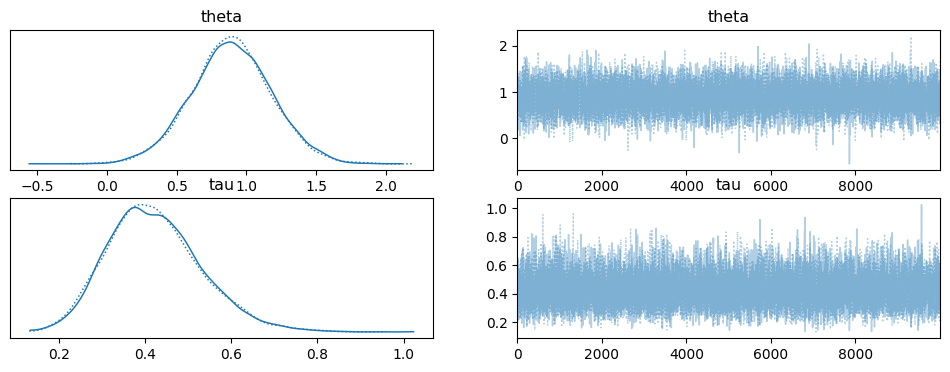

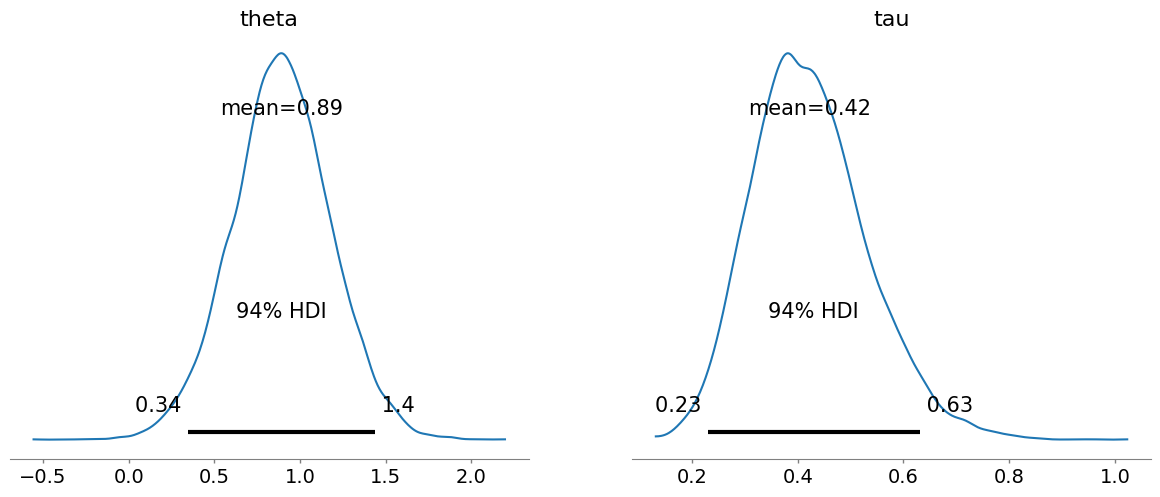

In [108]:
# Define the PyMC model using the following priors:
#    θ: Normal distribution
#    τ: Gamma distribution
with pm.Model() as model:
    
    # Initializing the prior for θ.
    theta = pm.Normal('theta', mu=0, sigma=10)
    
    # Initializing the prior for τ.
    tau = pm.Gamma('tau', alpha=(1 / 2), beta=(1 / 2))
    
    # Initializing likelihood.
    likelihood = pm.Normal('likelihood', mu=theta, tau=tau, observed=x)
    
    # Performing Bayesian inference.
    trace = pm.sample(10000, tune=100, chains=2, return_inferencedata=True)

# Viewing diagnostics and assessments.
az.plot_trace(trace)
az.plot_posterior(trace)

az.summary(trace)

As another example, we will perform inference wherein this time the prior for theta is a non normal distribution and the prior for tau is a non-gamma distribution:

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.18        3            2219.51 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.19        3            1688.80 draws/s   0:00:05   0:00:00

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.895,0.284,0.368,1.434,0.002,0.002,14005.0,12187.0,1.0
tau,0.437,0.111,0.237,0.641,0.001,0.001,18395.0,14100.0,1.0


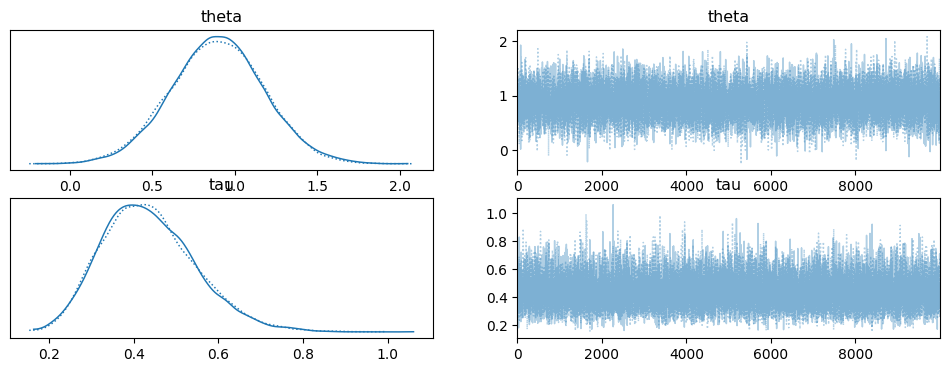

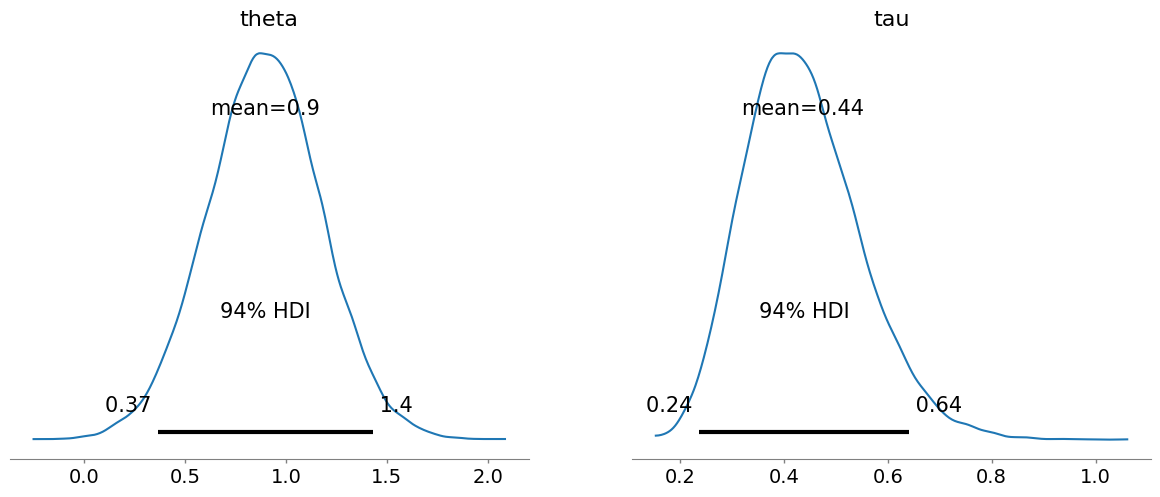

In [109]:
# Define the PyMC model using the following priors:
#    θ: Logistic distribution
#    τ: Exponential distribution
with pm.Model() as model:
    
    # Initializing the prior for θ.
    theta = pm.Logistic('theta', mu=0, s=10)
    
    # Initializing the prior for τ.
    tau = pm.Exponential('tau', lam=(1 / 2))
    
    # Initializing likelihood.
    likelihood = pm.Normal('likelihood', mu=theta, tau=tau, observed=x)
    
    # Performing Bayesian inference.
    trace = pm.sample(10000, tune=100, chains=2, return_inferencedata=True)

# Viewing diagnostics and assessments.
az.plot_trace(trace)
az.plot_posterior(trace)

az.summary(trace)

For a final demonstration, we will change the priors for the parameters again:

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.30        7            1855.27 draws/s   0:00:05   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.36        3            1710.90 draws/s   0:00:05   0:00:00

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.894,0.295,0.329,1.438,0.003,0.002,12640.0,10795.0,1.0
tau,0.415,0.108,0.218,0.617,0.001,0.001,16848.0,12463.0,1.0


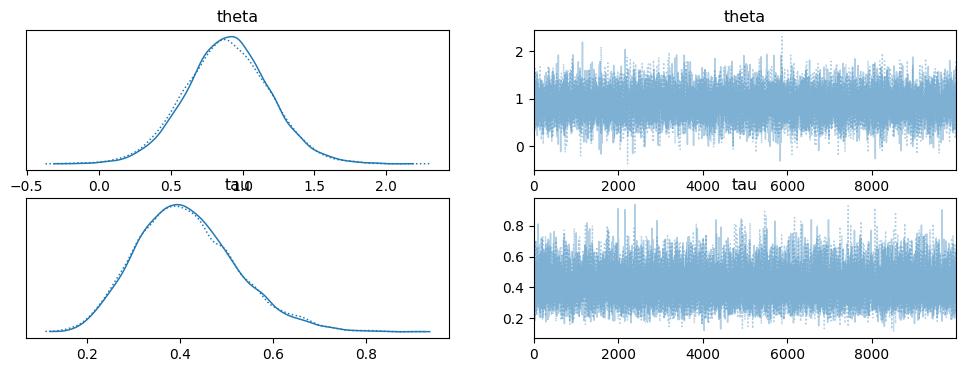

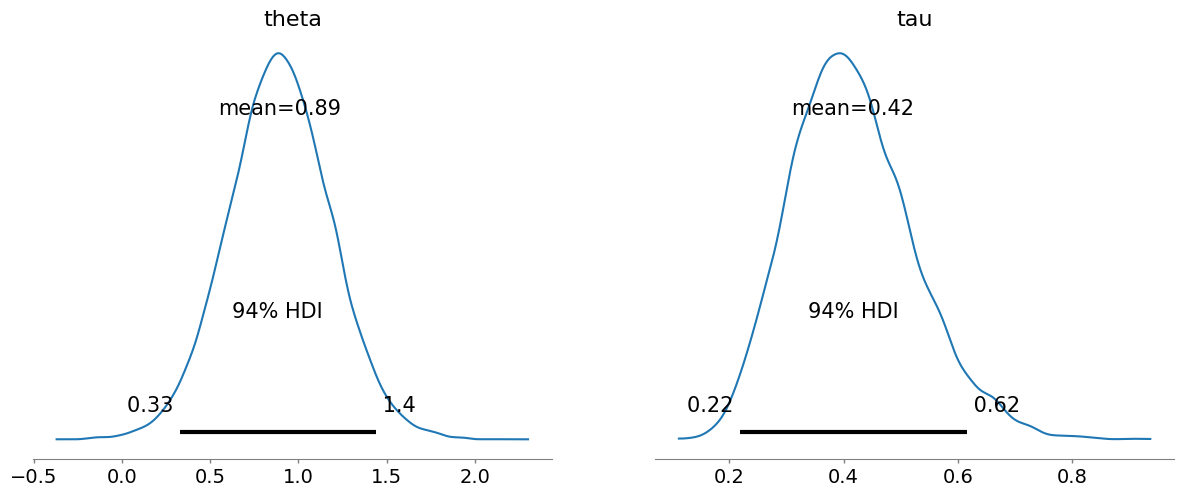

In [110]:
# Define the PyMC model using the following priors:
#    θ: Laplace distribution
#    τ: Weibull distribution
with pm.Model() as model:
    
    # Initializing the prior for θ.
    theta = pm.Laplace('theta', mu=0, b=10)
    
    # Initializing the prior for τ.
    tau = pm.Weibull('tau', alpha=(1 / 2), beta=(1 / 2))
    
    # Initializing the likelihood.
    likelihood = pm.Normal('likelihood', mu=theta, tau=tau, observed=x)
    
    # Performing Bayesian inference.
    trace = pm.sample(10000, tune=100, chains=2, return_inferencedata=True)

# Viewing diagnostics and assessments.
az.plot_trace(trace)
az.plot_posterior(trace)

az.summary(trace)

### Q3:

The slice sampling code below works as follows:

First, we start with an initial point `x` and a curve `f`. In the case of the example code, we have `f` as the pdf for the $Beta(1.5, 3)$ distribution. Then, we sample a value `y` uniformly from the interval $(0, f(x))$. This `y` becomes our *slice* under the curve, wherein we now search for an interval $(a, b)$ that contains `x` with the condition that $f(x) \gt y$.

Then, draw a random point `x_` uniformly from the interval $(a, b)$. If $f(x\_) \gt y$, accept `x_` as the new sample.

In the case that `x_` is not accepeted and `x_ < x`, we narrow the interval by setting the left boundary to `x_`. Similarly, if `x_ > x`, we narrow the interval by setting the right boundary to `x_`.

This sample then narrow step will be continuously repeated until a valid `x_` is found.

Finally, we use the found `x_` as the new starting point for a subsequent iteration.

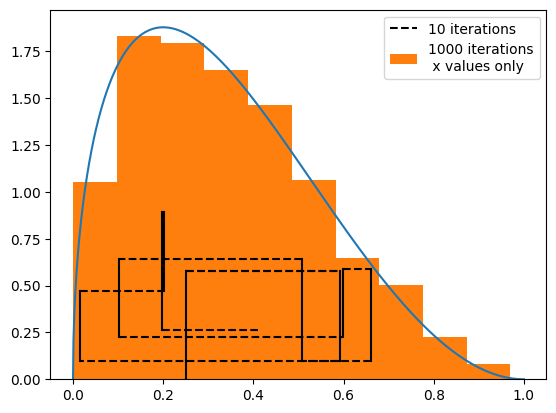

In [111]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();

We can perform slice-within-Gibbs sampling as follows:

For whichever parameter $\theta_{i, t}$ we wish to estimate, we can define the curve `f` as the unnormalized full conditional distribution $p(θ_{i, t + 1} | θ_{i, t}, x)$. We can use `slice_f_at_y` as the step to draw a new value for $\theta_{i}$, then use it as an update to bring about $\theta_{i, t + 1}$. The initial value for each Gibbs step is the current value of the parameter being updated. As usual, this process can be repeated arbitrarily, hence effectively performing Gibbs sampling.